In [40]:
import pandas as pd
import numpy as np
import geopandas as gp
import fiona
import os
from shapely.geometry import Polygon
from shapely.geometry import Point
from matplotlib import pyplot
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import json
import datetime
import pickle
from ipypb import track
from ipypb import chain
import seaborn as sn

os.chdir(r"C:\Users\User\Documents\Work\SDGs and AI\6.3.2")

### Create list of coordinates for retrieval

In [ ]:
### Read in EEA waterbase selected columns

col_to_keep = ['monitoringSiteIdentifier','parameterWaterBodyCategory','observedPropertyDeterminandCode',
               'phenomenonTimeSamplingDate','resultObservedValue',]

wqdb = pd.read_csv('./EEA_water_base/Waterbase_v2018_1_T_WISE4_DisaggregatedData.csv',usecols=col_to_keep,parse_dates=True)

### Read site metadata

site_meta = pd.read_csv('./EEA_water_base/Waterbase_v2018_1_WISE4_MonitoringSite_DerivedData.csv')

In [135]:
### filter for just sites with chlorophyll data and just lakes

deter = 'EEA_3164-01-0'

sites_data = wqdb[(wqdb.observedPropertyDeterminandCode==deter)&(wqdb.parameterWaterBodyCategory=='LW')]

sites_data['phenomenonTimeSamplingDate'] = pd.to_datetime(sites_data.phenomenonTimeSamplingDate)

del(wqdb)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [136]:
### Join lon lat to site data and create data and site list

sites_data = sites_data.merge(site_meta[['monitoringSiteIdentifier','lon','lat']],how='left',on='monitoringSiteIdentifier')

sites_data = sites_data[sites_data.lon.notnull()]

In [137]:
### convert to multi-level index

sites_data = sites_data.rename(columns={'monitoringSiteIdentifier':'sid','phenomenonTimeSamplingDate':'dt'})
sites = sites_data.set_index(['sid','dt']) #,verify_integrity=True

### remove duplicated indexes
# sites = sites.loc[~sites.index.duplicated(keep='first')]

## sort index to aid filtering
sites.sort_index(level=['sid','dt'], ascending=[1, 1], inplace=True)

## add variable for whether site-date pair has been checked has been checked
sites['checked'] = 0

In [141]:
### Convert data to spatial and change CRS
## NOTE: WISE data reported in ETRS89-GRS80 ('+proj=longlat +ellps=GRS80 +no_defs'), USGS use  '+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

geometry = [Point(xy) for xy in zip(sites['lon'],sites['lat'])]

crs= '+proj=longlat +ellps=GRS80 +no_defs' #'epsg:4258' #

sites = gp.GeoDataFrame(sites, crs=crs, geometry=geometry)

sites = sites.to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

### Landsat API call to check for coverage

https://earthexplorer.usgs.gov/inventory/documentation#access

https://pypi.org/project/landsatxplore/

In [14]:
sites = pd.read_pickle("sites.p")

In [30]:
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer

user = 'clement.attwood.18@ucl.ac.uk'
password = 'm9.iETxKMtZ6B,q'

api = landsatxplore.api.API(user,password)

In [34]:
# Create call for each site and each date

lag = 4                      # number of days to search either side of sample date
max_cloud_cover = 20         # max cloud cover for scene

platforms = ['LANDSAT_ETM_C1','LANDSAT_8_C1'] 

for sid,dt in track(sites[sites.checked==0].index):
     
    ## set checked to 1
    date = dt.strftime("%Y-%m-%d")
    sites.loc[(sid,date),'checked'] = 1
    
    ## set start end dates of search
    start = dt-datetime.timedelta(days=lag)
    end = dt+datetime.timedelta(days=lag)
    
    for platform in platforms:

        scenes = api.search(dataset = platform,
                            latitude = sites.loc[sid,'lat'][0],
                            longitude = sites.loc[sid,'lon'][0],
                            start_date = start.strftime("%Y-%m-%d"),
                            end_date = end.strftime("%Y-%m-%d"),
                            max_cloud_cover = max_cloud_cover)
        
        if platform=='LANDSAT_ETM_C1':
            
            sites.loc[(sid,date),'l7_scene_n4d20c'] = len(scenes)
            
            if len(scenes)>0:
                sites.loc[(sid,date),'l7_scene_id'] = scenes[0]['entityId']
                sites.loc[(sid,date),'l7_scene_dt'] = scenes[0]['modifiedDate']
                pickle.dump(scenes,open('./Landsat/Scenes/scene_'+str(scenes[0]['entityId'])+'.p','wb'))
            
        else:
        
            sites.loc[(sid,date),'l8_scene_n4d20c'] = len(scenes)
            
            if len(scenes)>0:
                sites.loc[(sid,date),'l8_scene_id'] = scenes[0]['entityId']
                sites.loc[(sid,date),'l8_scene_dt'] = scenes[0]['modifiedDate']
                pickle.dump(scenes,open('./Landsat/Scenes/scene_'+str(scenes[0]['entityId'])+'.p','wb'))
                

pickle.dump(sites,open('sites.p','wb'))

 [████████████████████████████████████████████████████████████] 687/687 [46:55<00:04, 4.10s/it]

In [35]:
(len(sites),len(sites[sites.checked==1]))

(21196, 21196)

### Change search criteria

In [110]:
sites = sites.rename(columns={'l7_scene_n':'l7_scene_n1d10c','l8_scene_n':'l8_scene_n1d10c'})

In [122]:
### Change checked back to 0 for site/date with no retrieved scenes

sites['checked'] = np.where((sites.l8_scene_id.isna()&sites.l7_scene_id.isna()),0,1)

### Metadata processing

In [45]:
list(sites)

['wb_cat',
 'determinand_id',
 'value',
 'lon',
 'lat',
 'geometry',
 'checked',
 'l7_scene_n1d10c',
 'l8_scene_n1d10c',
 'l7_scene_id',
 'l7_scene_dt',
 'l8_scene_id',
 'l8_scene_dt',
 'l7_scene_n4d20c',
 'l8_scene_n4d20c']

In [58]:
sites_anal = sites[sites.l7_scene_id.notna()|sites.l8_scene_id.notna()|sites.l7_scene_id.notna()|sites.l8_scene_id.notna()]

In [59]:
len(sites_anal)

5235

In [60]:
ziplist = zip(sites_anal.index.get_level_values(0),sites_anal.index.get_level_values(1),
              sites_anal.l7_scene_id,sites_anal.l8_scene_id)

for sid,dt,l7_scene_id,l8_scene_id in track(ziplist,len(sites)):
    
    date = dt.strftime("%Y-%m-%d")
    
    if (isinstance(l7_scene_id,str)==True):
        sc_meta7 = pickle.load(open('./Landsat/Scenes/scene_'+str(l7_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l7_display_id'] = sc_meta7[0]['displayId']
        sites_anal.loc[(sid,date),'l7_acquisition_dt'] = sc_meta7[0]['acquisitionDate']
        
        del(sc_meta7)

    elif (isinstance(l8_scene_id,str)==True):
        sc_meta8 = pickle.load(open('./Landsat/Scenes/scene_'+str(l8_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l8_display_id'] = sc_meta8[0]['displayId']
        sites_anal.loc[(sid,date),'l8_acquisition_dt'] = sc_meta8[0]['acquisitionDate']
        
        del(sc_meta8)

 [██████████████##############################################] 5212/21196 [00:25<00:00, 0.00s/it]

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Return string of processing status from Display ID

https://lta.cr.usgs.gov/DD/landsat_dictionary.html#landsat_product_id

In [61]:
display_ids7 = sites_anal[(sites_anal['l8_scene_id'].notna())|(sites_anal['l7_scene_id'].notna())].l7_display_id
display_ids8 = sites_anal[(sites_anal['l8_scene_id'].notna())|(sites_anal['l7_scene_id'].notna())].l8_display_id

display_ids = display_ids8.append(display_ids7)
display_ids = display_ids.dropna()

LLLL = [i[5:9] for i in display_ids]
CCTX = [i[-5:] for i in display_ids]

list(set(LLLL)),list(set(CCTX))

(['L1GT', 'L1TP'], ['01_T2', '01_T1'])

#### Number of scenes per site

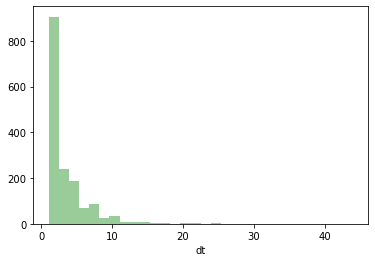

In [42]:
sites_anal = sites[(sites['l7_scene_id'].notna())|(sites['l8_scene_id'].notna())].reset_index()
temp = sites_anal.groupby('sid').count()
sn.distplot(temp.dt,kde=False,bins=30,color='g')

In [63]:
sites.loc['EL000200030020H500',:]

,wb_cat,determinand_id,value,lon,lat,geometry,checked,l7_scene_n1d10c,l8_scene_n1d10c,l7_scene_id,l7_scene_dt,l8_scene_id,l8_scene_dt,l7_scene_n4d20c,l8_scene_n4d20c
dt,,,,,,,,,,,,,,,
2013-06-12,LW,EEA_3164-01-0,0.592500,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,LE71830342013160ASN00,2013-06-09T08:51:46,LC81840332013159LGN01,2017-05-04T01:42:37,3.0,2.0
2013-07-24,LW,EEA_3164-01-0,0.457000,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,NaN,NaN,LC81840332013207LGN02,2018-05-27T01:15:20,0.0,2.0
2013-08-20,LW,EEA_3164-01-0,0.531400,22.28925,37.93007,POINT (22.28925 37.93007),1,2.0,1.0,LE71840332013231ASN00,2013-08-19T09:00:23,LC81830342013232LGN01,2017-05-02T18:32:16,NaN,NaN
2013-09-25,LW,EEA_3164-01-0,1.005275,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,LE71830342013272ASN00,2013-09-29T08:58:38,LC81840332013271LGN01,2017-05-02T00:08:49,1.0,2.0
2014-05-13,LW,EEA_3164-01-0,0.481700,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,LE71830342014131ASN00,2014-05-11T08:59:20,LC81840332014130LGN01,2017-04-22T16:39:55,1.0,2.0
2014-06-17,LW,EEA_3164-01-0,0.221200,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,LE71840342014170ASN00,2014-06-19T09:07:38,NaN,NaN,1.0,0.0
2014-07-15,LW,EEA_3164-01-0,0.458600,22.28925,37.93007,POINT (22.28925 37.93007),1,1.0,0.0,LE71830342014195ASN00,2014-07-14T09:00:21,NaN,NaN,NaN,NaN
2014-08-21,LW,EEA_3164-01-0,0.576300,22.28925,37.93007,POINT (22.28925 37.93007),1,1.0,0.0,LE71840342014234ASN00,2014-08-22T09:02:41,NaN,NaN,NaN,NaN
2014-09-03,LW,EEA_3164-01-0,0.627450,22.28925,37.93007,POINT (22.28925 37.93007),1,0.0,0.0,LE71830342014243ASN00,2014-08-31T09:00:29,LC81840342014242LGN01,2017-04-19T22:15:38,1.0,1.0
